In [3]:
# Library imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
def predict(point, betas):
    #point and betas are np array
    #len(point) should be len(betas) - 1
    pass

def mse(data, betas):
    rows, cols = data.shape
    loss = 0
    for i in range(rows):
        u = betas[0] + np.dot(betas[1:], data[i][:cols - 1].T)
        loss += pow(data[i][cols - 1] - u, 2)
    loss *= 1 / rows
    return loss

def iterate(data_train, data_test, betas, epochs, learning_rate):
    metrics = {
        'loss_train': [mse(data_train, betas)],
        'loss_test': [mse(data_test, betas)],
    }
    rows, cols = data_train.shape
    for k in range(epochs):
        dbetas = np.zeros(len(betas))
        for i in range(rows):
            temp = data_train[i, cols - 1] - (betas[0] + np.dot(betas[1:], data_train[i][:cols - 1].T))
            dbetas[0] += temp
            dbetas[1:] += temp * data_train[i][:cols - 1]
        dbetas *= -2 / rows
        betas -= dbetas * learning_rate
        metrics['loss_train'].append(mse(data_train, betas))
        metrics['loss_test'].append(mse(data_test, betas))
    return metrics

In [9]:
data = pd.read_csv('linreg_data.csv').to_numpy()
train, test = train_test_split(data, test_size=0.1, shuffle=True)

In [24]:
eps = 100
lr = 0.1
betas = np.zeros(train.shape[1])

metrics = iterate(train, test, betas, eps, lr)

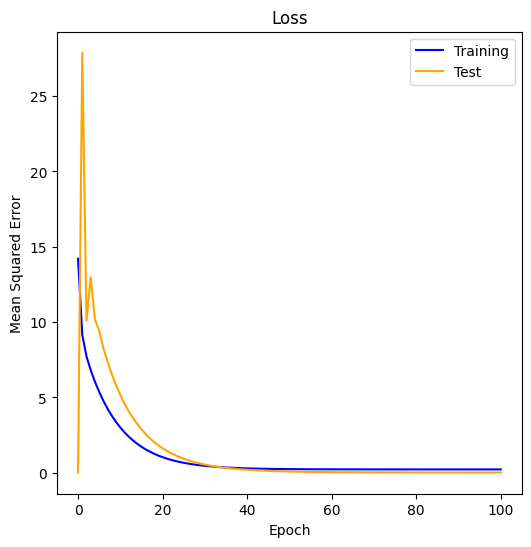

In [37]:
plt.figure(figsize=(6, 6))
plt.plot(range(eps + 1), metrics['loss_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['loss_test'], c='orange', label='Test')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.show()

In [30]:
print(metrics['loss_train'][eps])

0.2200429678585119


In [44]:
insurance = pd.read_csv('insurance.csv')
insurance['sex'] = insurance['sex'].apply(lambda x: (x == 'male') * 1)
insurance['smoker'] = insurance['smoker'].apply(lambda x: (x == 'yes') * 1)
regions = ['northeast', 'southeast', 'southwest', 'northwest']
regions = {regions[i]: i for i in range(len(regions))}
insurance['region'] = insurance['region'].apply(lambda x: regions[x])
print(insurance.head(10))
insurance = insurance.to_numpy()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,2,16884.92400
1,18,1,33.770,1,0,1,1725.55230
2,28,1,33.000,3,0,1,4449.46200
3,33,1,22.705,0,0,3,21984.47061
4,32,1,28.880,0,0,3,3866.85520
5,31,0,25.740,0,0,1,3756.62160
6,46,0,33.440,1,0,1,8240.58960
7,37,0,27.740,3,0,3,7281.50560
8,37,1,29.830,2,0,0,6406.41070
9,60,0,25.840,0,0,3,28923.13692


In [45]:
betas = np.zeros(insurance.shape[1])
eps = 100
lr = 0.1

train, test = train_test_split(insurance, test_size=0.1, shuffle=True)
metrics = iterate(train, test, betas, eps, lr)

KeyError: 0

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(range(eps + 1), metrics['loss_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['loss_test'], c='orange', label='Test')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.show()